# Rainfall Prediction with Machine Learning

I did this rainfall prediction project as part of the IBM Machine Learning with Python course on Coursera; I was curious about how machine learning could be applied to something as unpredictable as weather.

What really excited me about this project was the chance to work with actual meteorological data rather than clean, academic datasets. I wanted to understand what it's really like to build a classifier from the ground up and see how different algorithms perform on the same problem. Plus, who hasn't wondered if they could predict whether to bring an umbrella tomorrow?

## Project Objectives

Through working on this project, I aimed to:

* Explore and perform feature engineering on a real-world dataset to understand how raw data becomes model-ready
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate my model by interpreting various performance metrics and visualizations to really understand what the numbers mean
* Implement different classifiers by updating my pipeline to see how various algorithms compare
* Use appropriate parameter sets for grid search optimization in each case

## Models

Here, I compared Random Forest, XGBoost, and Logistic Regression classifiers.

We begin by installing the relevant libraries.


In [35]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install xgboost

And importing them.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from xgboost import XGBClassifier

We must also have a set random state for reproducibility.

In [37]:
random_state = 7

# Load and Process the Data

We see the structure of the data and drop rows with missing values.

In [38]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [39]:
df.count()

,0
Date,145460
Location,145460
MinTemp,143975
MaxTemp,144199
Rainfall,142199
Evaporation,82670
Sunshine,75625
WindGustDir,135134
WindGustSpeed,135197
WindDir9am,134894


In [40]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

We see that we still have around 56,000 observations to use. We will not need to impute missing values then.

We would like to predict today's rainfall using historical weather data that is provided to us, up until yesterday's.

As such, we'll have to rename the columns.

Noting that weather patterns cannot be the same for a landmass as big as Australia, let's restrict our modeling to one location.

Weather is also seasonal; we would like to map the dates in the set to seasons since date by itself is not really as informative for us in this case.

I am choosing Sydney, since a very good friend of mine lives there and I would like to be able to tell him whether he should carry his umbrella or not today!

In [41]:
def date_to_season(date):
  month = date.month
  if month in [12,1,2]:
    return 'Summer'
  elif month in [3,4,5]:
    return 'Autumn'
  elif month in [6,7,8]:
    return 'Winter'
  elif month in [9,10,11]:
    return 'Spring'

# rename the columns to predict the weather for today
df = df.rename(columns={'RainToday': 'RainYesterday', 'RainTomorrow': 'RainToday'})

# we only want to predict the weather for Sydney
df = df[df.Location.isin(['Sydney', 'SydneyAirport'])]

# convert date to seasons
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)

df = df.drop(columns='Date')

# let's see what we have so far
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 4560 entries, 31168 to 36528
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       4560 non-null   object 
 1   MinTemp        4560 non-null   float64
 2   MaxTemp        4560 non-null   float64
 3   Rainfall       4560 non-null   float64
 4   Evaporation    4560 non-null   float64
 5   Sunshine       4560 non-null   float64
 6   WindGustDir    4560 non-null   object 
 7   WindGustSpeed  4560 non-null   float64
 8   WindDir9am     4560 non-null   object 
 9   WindDir3pm     4560 non-null   object 
 10  WindSpeed9am   4560 non-null   float64
 11  WindSpeed3pm   4560 non-null   float64
 12  Humidity9am    4560 non-null   float64
 13  Humidity3pm    4560 non-null   float64
 14  Pressure9am    4560 non-null   float64
 15  Pressure3pm    4560 non-null   float64
 16  Cloud9am       4560 non-null   float64
 17  Cloud3pm       4560 non-null   float64
 18  Temp9am 

Now, let's define the features and target dataframes, as well as evaluating if our data needs to be stratified (in case of imbalance).

In [42]:
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

y.value_counts()

,count
RainToday,
No,3429
Yes,1131


Welp, we can see that the data is quite imbalanced. We'd need to stratify it.

Also, note that by looking at the data, the chance of rain is around 33%. Our model must do better than that hopefully!

After splitting the data, we would also like to transform the numeric and categorical features.

* Numeric features need to be scaled
* Categorical features need to be one-hot encoded.

In [76]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=random_state)

# automatically detect numerical and categorical columns and assign them to
# separate set of features
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# define separate transformers and combine into a single preprocessing transformer

## scale numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

## one-hot categorical features
categorical_transformer = Pipeline(steps=[('onehot',
                                           OneHotEncoder(
                                               handle_unknown='ignore'))])

## combine in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## Create and Fit the Model

Next, let's create a pipeline with the RandomForest classifier. We shall also define the parameter grid to use in our cross-validation grid search model optimizer.

In [48]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=random_state))
])

param_grid = {
    'classifier__n_estimators': [50,100,150],
    'classifier__max_depth': [None, 10,20,30],
    'classifier__min_samples_split': [2,5]
}

# define the cross-validation split and method
cv = StratifiedKFold(n_splits=5, shuffle=True)

# initialize the grid search
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='accuracy',
                           verbose=2)

# fit the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=7))]),
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [49]:
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")


Best parameters found: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


## Test the Best Model

In [53]:
test_score = grid_search.score(X_test, y_test)
print(f"Test set score: {test_score:.2f}")

Test set score: 0.84


Our classifier does a pretty good job; compared to a random chance of 33% for rain, our classifier can correctly predict about 84% of the time whether it will rain today in Sydney. We must not stop here though. Let's take a closer look at the results with the other metrics.

In [61]:
y_pred = grid_search.predict(X_test)
print("Classification Report:")
report_model_rf = classification_report(y_test, y_pred)
print(report_model_rf)

Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.94      0.90       686
         Yes       0.74      0.52      0.61       226

    accuracy                           0.84       912
   macro avg       0.80      0.73      0.75       912
weighted avg       0.83      0.84      0.83       912



What this tells us:
* The classifier outperforms random guessing: the chance of rain is roughly 33%, but our model achieves 84% accuracy on the test set.
* The best cross-validation score was 0.85, showing the model generalizes well.
* However, the classification report reveals some imbalance: the precision and recall for "Yes" (rain) are lower than for "No," suggesting the model is better at predicting dry days than rainy ones.

Let's visualize the classification report with a confusion matrix to better see these inferences at a glance.

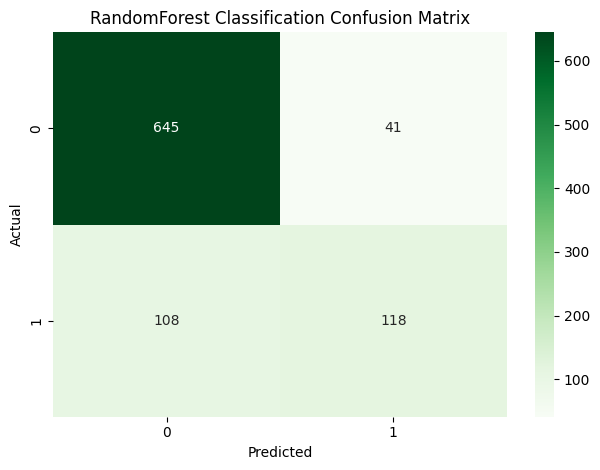

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

# Set the title and labels
plt.title('RandomForest Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

Let's now see which features are more important than others for the model.

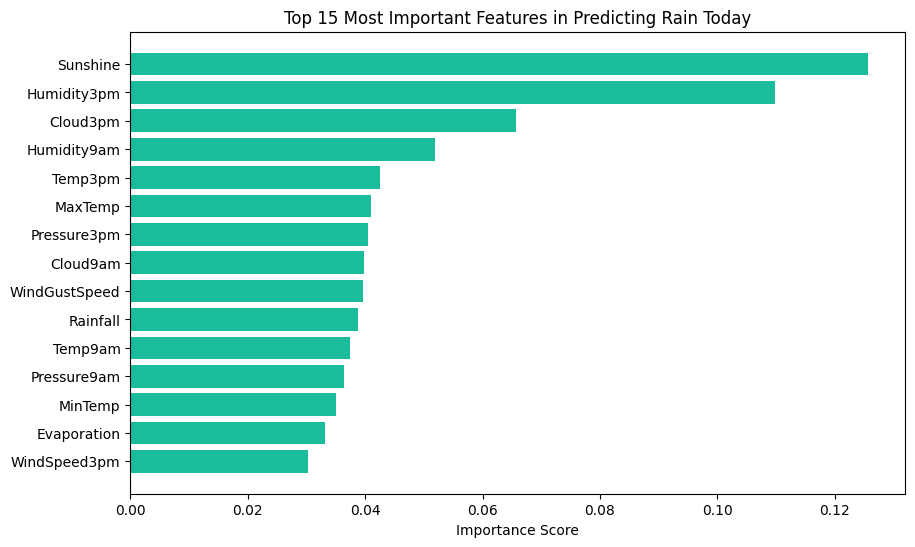

In [60]:
# we reverse-engineer the categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 15
top_features = importance_df.head(N)

# plot the features by importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='#1abc9c')
plt.gca().invert_yaxis()
plt.title(f'Top {N} Most Important Features in Predicting Rain Today')
plt.xlabel('Importance Score')
plt.show()

# Try Other Models: XGBoost and LogisticRegression
We simply update our pipeline and parameter grid and fit our `grid_search` again.

In [80]:
# XGB is strict, so map any string values to numeric ones
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

In [69]:
# XGBoost
pipeline.set_params(classifier=XGBClassifier(random_state=random_state,
                                             eval_metric='logloss'))

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}
grid_search.param_grid = param_grid

## fit
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; total time=   0.1s
[CV] END classifier__colsample_bytree=0.8, classifier__learnin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.3],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       686
           1       0.74      0.58      0.65       226

    accuracy                           0.84       912
   macro avg       0.80      0.76      0.77       912
weighted avg       0.84      0.84      0.84       912



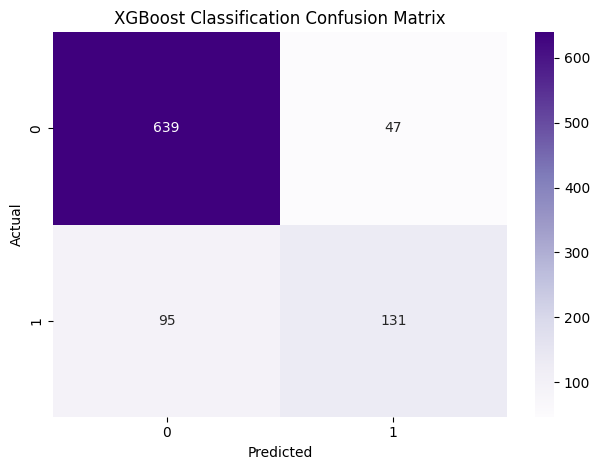

In [81]:
y_pred_xgb = grid_search.predict(X_test)
report_model_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report")
print(report_model_xgb)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Purples', fmt='d')

# Set the title and labels
plt.title('XGBoost Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

* Cross-validation and test scores were comparable to Random Forest, showing good generalization.

* XGBoost was better at predicting the majority class ("No rain"), but its recall for rainy days ("Yes") was lower—similar to Random Forest and typical for imbalanced problems.

* XGBoost handles large feature sets and complex patterns efficiently, making it well-suited for structured data like weather records.

Next, let's look at how logistic regression performs.

In [87]:
pipeline.set_params(classifier=LogisticRegression(random_state=random_state))
grid_search.estimator = pipeline
param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}
grid_search.param_grid = param_grid

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.5s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=7))]),
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='accuracy', verbose=2)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       686
           1       0.68      0.54      0.61       226

    accuracy                           0.82       912
   macro avg       0.77      0.73      0.75       912
weighted avg       0.82      0.82      0.82       912



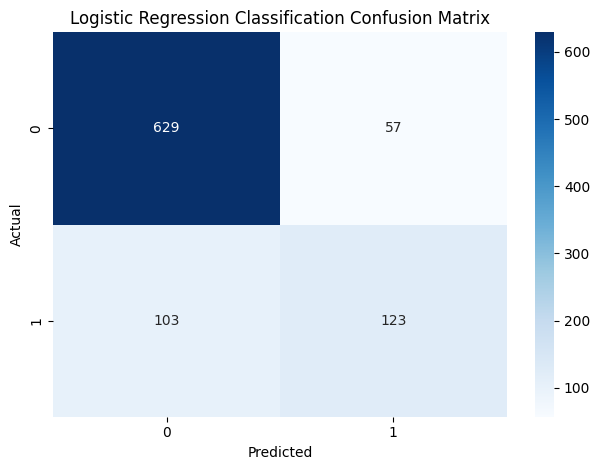

In [88]:
y_pred_lr = grid_search.predict(X_test)
report_model_lr = classification_report(y_test, y_pred_lr)

print("Classification Report")
print(report_model_lr)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Logistic Regression Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

* Logistic Regression achieved good overall accuracy but slightly less than Random Forest and XGBoost.
* The model is simple and interpretable, making it useful for understanding how input features affect the predictions.
* Performance suffers on imbalanced data, especially for predicting "Yes" (rain) days—lower recall compared to tree-based models.
* Works well as a baseline classifier, and results here show it generalizes well, but tree models capture nonlinear relationships better.

# Conclusion

In this project, we explored the use of machine learning to predict rainfall in Sydney with real-world weather data. The process involved thorough data preprocessing, feature engineering, and treatment of missing values to ensure reliable model performance.

Tree-based models like Random Forest and XGBoost delivered the highest accuracy, handling the dataset’s complexity and the natural class imbalance well. Logistic Regression worked as an interpretable baseline, but was less effective for predicting rainy days compared to the more sophisticated models.

Tuning model parameters via grid search helped further optimize performance. For future work, improvements like additional feature selection, or more ensemble approaches could enhance the model’s ability to predict rain.

Overall, these results demonstrate strong predictive potential and a solid starting point for operational rainfall forecasting!